-0.09706626816763125 * I(0) + 0.17141282644776926 * Z(0) + 0.1714128264477692 * Z(1) + -0.22343153690813433 * Z(2) + -0.22343153690813433 * Z(3) + 0.16868898170361205 * (Z(0) @ Z(1)) + 0.12062523483390411 * (Z(0) @ Z(2)) + 0.16592785033770338 * (Z(0) @ Z(3)) + 0.16592785033770338 * (Z(1) @ Z(2)) + 0.12062523483390411 * (Z(1) @ Z(3)) + 0.17441287612261575 * (Z(2) @ Z(3)) + -0.04530261550379926 * (X(0) @ X(1) @ Y(2) @ Y(3)) + 0.04530261550379926 * (X(0) @ Y(1) @ Y(2) @ X(3)) + 0.04530261550379926 * (Y(0) @ X(1) @ X(2) @ Y(3)) + -0.04530261550379926 * (Y(0) @ Y(1) @ X(2) @ X(3))
第 1 步: β = -0.055569, E = -0.09706627 Ha
第 2 步: β = -0.111077, E = -0.09725145 Ha
第 3 步: β = -0.166435, E = -0.09780615 Ha
第 4 步: β = -0.221512, E = -0.09891258 Ha
第 5 步: β = -0.276120, E = -0.10074882 Ha
第 6 步: β = -0.330002, E = -0.10348583 Ha
第 7 步: β = -0.382828, E = -0.10728331 Ha
第 8 步: β = -0.434182, E = -0.11228435 Ha
第 9 步: β = -0.483568, E = -0.11860894 Ha
第 10 步: β = -0.530418, E = -0.12634664 Ha
第 11 步

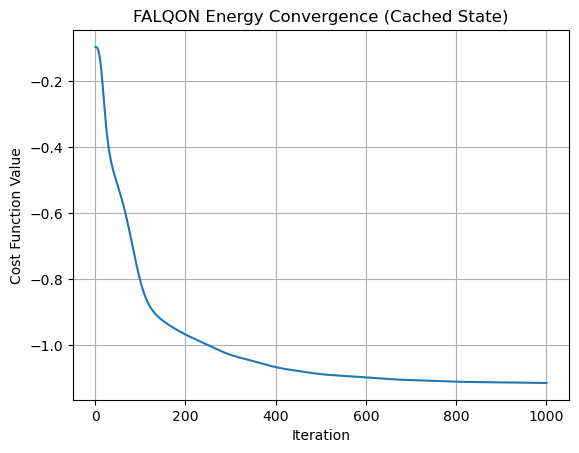

In [2]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.qchem import molecular_hamiltonian
from pennylane import commutator
from scipy.linalg import expm
import matplotlib.pyplot as plt

# ========== 1. 分子设置 ==========
import pennylane as qml
from pennylane import numpy as np
from pennylane.qchem import molecule
from pennylane import commutator
import matplotlib.pyplot as plt

import pennylane as qml
from pennylane import numpy as np
from pennylane.qchem import molecule
from pennylane import commutator
import matplotlib.pyplot as plt

# 1. 设置分子结构
from pennylane.qchem import molecular_hamiltonian

from pyscf import gto, scf
from openfermionpyscf import run_pyscf
from openfermion.transforms import jordan_wigner
from openfermion.linalg import get_sparse_operator
import scipy

from openfermion import MolecularData
from openfermionpyscf import run_pyscf
from openfermion.transforms import jordan_wigner
from openfermion.linalg import get_sparse_operator

# Step 1: 构造 OpenFermion 分子对象（不要用 PySCF 的 gto.Mole）
geometry = [('H', (0.0, 0.0, 0.0)),
            ('H', (0.0, 0.0, 0.74))]  # 单位为 Å
basis = 'sto-3g'
multiplicity = 1
charge = 0

molecule = MolecularData(
    geometry=geometry,
    basis=basis,
    multiplicity=multiplicity,
    charge=charge
)

# Step 2: 运行 PySCF 计算（RHF + 哈密顿量）
molecule = run_pyscf(molecule, run_scf=True)

# Step 3: Jordan-Wigner 变换为 Qubit Hamiltonian
fermionic_hamiltonian = molecule.get_molecular_hamiltonian()
qubit_hamiltonian = jordan_wigner(fermionic_hamiltonian)

# Step 4: 转换为稀疏矩阵（如需矩阵形式演化）
from pennylane import PauliX, PauliY, PauliZ, Identity, Hamiltonian

def openfermion_to_qml_hamiltonian(qubit_op, n_qubits):
    coeffs = []
    ops = []
    for term, coef in qubit_op.terms.items():
        if len(term) == 0:
            ops.append(Identity(0))
        else:
            op_list = []
            for qubit_idx, pauli in term:
                if pauli == 'X':
                    op_list.append(PauliX(qubit_idx))
                elif pauli == 'Y':
                    op_list.append(PauliY(qubit_idx))
                elif pauli == 'Z':
                    op_list.append(PauliZ(qubit_idx))
            op = op_list[0] if len(op_list) == 1 else qml.prod(*op_list)
            ops.append(op)
        coeffs.append(np.real(coef))  # 只保留实部
    return Hamiltonian(coeffs, ops)

# 调用转换函数
n_qubits = molecule.n_qubits
cost_h = openfermion_to_qml_hamiltonian(qubit_hamiltonian, n_qubits)

print(cost_h)

def decompose_pauli_rot(theta, pauli_string, wires):
    # 1. Basis change：将非Z的泡利门旋转到Z基
    for p, w in zip(pauli_string, wires):
        if p == "X":
            qml.Hadamard(wires=w)
        elif p == "Y":
            qml.RX(-np.pi/2, wires=w)
        # Z 和 I 不需要变换

    # 2. 用 CNOT 链叠加 Z ⊗ Z ⊗ ... 结构
    for i in range(len(wires) - 1):
        qml.CNOT(wires=[wires[i], wires[i+1]])

    # 3. 执行 Z 轴旋转
    qml.RZ(2 * theta, wires=wires[-1])

    # 4. 还原 CNOT 链
    for i in reversed(range(len(wires) - 1)):
        qml.CNOT(wires=[wires[i], wires[i+1]])

    # 5. Basis unchange：变换回去
    for p, w in zip(pauli_string, wires):
        if p == "X":
            qml.Hadamard(wires=w)
        elif p == "Y":
            qml.RX(np.pi/2, wires=w)

def build_driver_h(n):
    return qml.Hamiltonian([1.0] * n, [qml.PauliX(i) for i in range(n)])

driver_h = build_driver_h(n_qubits)

def build_commutator_hamiltonian(H_d, H_c):
    comm_terms = []
    coeffs_d, ops_d = H_d.terms()
    coeffs_c, ops_c = H_c.terms()
    for c1, op1 in zip(coeffs_d, ops_d):
        for c2, op2 in zip(coeffs_c, ops_c):
            try:
                comm = commutator(op1, op2)
                if isinstance(comm, qml.ops.op_math.Sum) and len(comm.operands) == 0:
                    continue
                comm_terms.append(1j * c1 * c2 * comm)
            except:
                continue
    return sum(comm_terms).simplify()

comm_h = build_commutator_hamiltonian(driver_h, cost_h)

# ========== 2. Ansatz 和测量电路 ==========
def extract_ops_recursive(op):
    """递归提取最底层 PauliX/Y/Z/Identity 操作"""
    if hasattr(op, "operands"):  # 是 Prod 等复合操作
        ops = []
        for sub_op in op.operands:
            ops.extend(extract_ops_recursive(sub_op))
        return ops
    else:
        return [op]

def op_to_pauli_string_and_wires(op):
    """构建 PauliRot 所需的 (pauli_word, wires)，支持任意嵌套 Prod"""
    valid = {"PauliX": "X", "PauliY": "Y", "PauliZ": "Z", "Identity": "I"}
    ops = extract_ops_recursive(op)

    pauli_word = ""
    wires = []

    for sub_op in ops:
        if sub_op.name not in valid:
            raise ValueError(f"Unsupported sub-op: {sub_op.name}")
        pauli_word += valid[sub_op.name]
        wires.append(sub_op.wires[0])

    return pauli_word, wires


def falqon_layer(beta_k, cost_h, driver_h, delta_t):
    for c, op in zip(cost_h.coeffs, cost_h.ops):
        pauli_word, wires = op_to_pauli_string_and_wires(op)
        if len(wires) <= 2:
            qml.PauliRot(2 * c * delta_t, pauli_word, wires=wires)
        else:
            decompose_pauli_rot(c * delta_t, pauli_word, wires)

    for c, op in zip(driver_h.coeffs, driver_h.ops):
        pauli_word, wires = op_to_pauli_string_and_wires(op)
        if len(wires) <= 2:
            qml.PauliRot(2 * c * beta_k * delta_t, pauli_word, wires=wires)
        else:
            decompose_pauli_rot(c * beta_k * delta_t, pauli_word, wires)



def build_falqon_ansatz(cost_h, driver_h, delta_t):
    def ansatz(beta, **kwargs):
        for w in dev.wires:
            qml.Hadamard(wires=w)
        for k in range(len(beta)):
            falqon_layer(beta[k], cost_h, driver_h, delta_t)
    return ansatz

def expval_circuit(beta, measurement_h):
    ansatz = build_falqon_ansatz(cost_h, driver_h, delta_t)
    ansatz(beta)
    return qml.expval(measurement_h)

# ========== 3. 核心：状态缓存方式实现 FALQON ==========
from scipy.linalg import expm

def evolve(state, hamiltonian, delta_t):
    H_mat = qml.matrix(hamiltonian, wire_order=range(n_qubits))
    U = expm(-1j * delta_t * H_mat)
    return U @ state

def measure(state, hamiltonian):
    H_mat = qml.matrix(hamiltonian, wire_order=range(n_qubits))
    return np.real(np.vdot(state, H_mat @ state))

def falqon_state_cached(n, beta_1, delta_t):
    dim = 2 ** n_qubits
    state = np.ones(dim) / np.sqrt(dim)  # 初始 |+>^n 态

    beta = [beta_1]
    energies = []

    for i in range(n):
        state = evolve(state, cost_h, delta_t)
        state = evolve(state, driver_h, delta_t * beta[-1])

        # 计算 comm 哈密顿量期望值，得到 beta_k+1
        beta_k1 = -measure(state, comm_h)

        # 下一轮用新的 beta
        beta.append(beta_k1)

        # 计算 cost energy
        energy = measure(state, cost_h)
        energies.append(energy)

        print(f"第 {i+1} 步: β = {beta_k1:.6f}, E = {energy:.8f} Ha")

    return beta, energies

# ========== 4. 运行 ==========
n = 1000
beta_1 = 0.0
delta_t = 0.03


dev = qml.device("default.qubit", wires=n_qubits)

# ✅ 保留原结构的 cost_fn（仍可用于验证）
cost_fn = qml.QNode(expval_circuit, dev, interface="autograd")

# 运行主过程
res_beta, res_energies = falqon_state_cached(n, beta_1, delta_t)
#print(qml.draw(transpiled_qnode)(res_beta[:2]))

# ion-trap 架构，无需 transpile，直接使用原始 ansatz
ansatz = build_falqon_ansatz(cost_h, driver_h, delta_t)

@qml.qnode(dev)
def iontrap_qnode(beta):
    ansatz(beta)
    return qml.expval(cost_h)

# 绘图看结构
print(qml.draw(iontrap_qnode)(res_beta[:2]))

transpiled_qnode = qml.QNode(transpiled_ansatz, dev)





# ========== 5. 可视化 ==========
plt.plot(range(1, n+1), res_energies)
plt.xlabel("Iteration")
plt.ylabel("Cost Function Value")
plt.title("FALQON Energy Convergence (Cached State)")
plt.grid(True)
plt.show()
